In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tqdm

In [3]:
import torch

# Penalty for misclassified normal transcation

- [Minimum wage in DE](https://www.google.com/search?client=safari&rls=en&q=germany+hourly+pay&ie=UTF-8&oe=UTF-8)
    - €9.19
- [Minimum wage in UK](https://www.gov.uk/national-minimum-wage-rates)
    - 25 and over : £8.21
    - 21 to 24 : £7.70
    - 18 to 20 : £6.15
- [Pound_to_Euros](https://www.google.com/search?client=safari&rls=en&sxsrf=ACYBGNTcBXXo56cjcxGtjvDJsYxVHAIsXQ%3A1571206181009&ei=JbSmXdsWhKSYBZqkl7AP&q=pound+euro+exchange+rate&oq=pound+euro+exchange+rate&gs_l=psy-ab.3..0i203l10.58549.61738..61805...1.0..0.475.3739.0j21j4-2......0....1..gws-wiz.......35i39j0j0i131j0i67j0i131i67j0i20i263j0i10i203.12vb-27mARs&ved=0ahUKEwibvaaSj6DlAhUEEqYKHRrSBfYQ4dUDCAo&uact=5)
    - £1 = €1.16
    
## Penalty for a call (misclassified normal transcation)
- penalty for single misclassifciation = minimum wage per a hour * (60 mins / time required to make a single call)

In [4]:
pound_to_euros = 1.16

minimum_wage_de = 9.19

uk_age_ratio = [1/3, 1/3, 1/3]
minimum_wage_uk = ((8.21*uk_age_ratio[0]+
                    7.70*uk_age_ratio[1]+
                    6.15*uk_age_ratio[2]))*pound_to_euros

mins_required_to_make_a_call = 5

penalty_de = minimum_wage_de / (60/mins_required_to_make_a_call)
penalty_uk = minimum_wage_uk / (60/mins_required_to_make_a_call)

print('penaly_de : ', penalty_de)
print('penalty_uk : ', penalty_uk)

penaly_de :  0.7658333333333333
penalty_uk :  0.7108222222222221


In [5]:
df_novelty = pd.read_pickle('training_history/novelty/novelty.pkl')
df_anomaly = pd.read_pickle('training_history/anomaly/anomaly.pkl')
df_anomaly_weighted = pd.read_pickle('training_history/anomaly_weighted/anomaly_weighted.pkl')

In [6]:
df_novelty['AUROC'] = [0.9988, 0.9769, 0.9815, 0.9768, 0.9877]
df_anomaly['AUROC'] = [0.9958, 0.9701, 0.9629, 0.9867, 0.9803]
df_anomaly_weighted['AUROC'] = [0.9980, 0.9634, 0.9633, 0.9936, 0.9685]

In [7]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [8]:
df_novelty

,Accuracy,TotalLoss,AUROC
0,0.987,469857.904,0.999
1,0.976,563655.447,0.977
2,0.978,695996.748,0.982
3,0.960,659291.463,0.977
4,0.980,700572.502,0.988


In [9]:
df_anomaly

,Accuracy,TotalLoss,AUROC
0,0.962,1105648.837,0.996
1,0.953,1158064.481,0.970
2,0.934,1460727.184,0.963
3,0.923,1337348.616,0.987
4,0.958,1011171.275,0.980


In [10]:
df_anomaly_weighted

,Accuracy,TotalLoss,AUROC
0,0.988,391208.574,0.998
1,0.963,706369.191,0.963
2,0.940,1392080.584,0.963
3,0.971,699065.392,0.994
4,0.963,944902.355,0.969


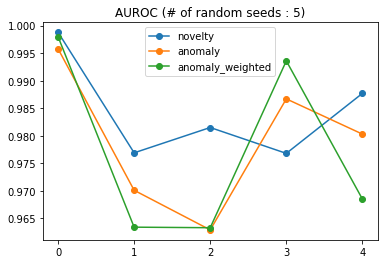

In [68]:
plt.plot(['0', '1', '2', '3', '4'], df_novelty['AUROC'], label='novelty', marker='o')
plt.plot(['0', '1', '2', '3', '4'], df_anomaly['AUROC'], label='anomaly', marker='o')
plt.plot(['0', '1', '2', '3', '4'], df_anomaly_weighted['AUROC'], label='anomaly_weighted', marker='o')
plt.legend()
plt.title('AUROC (# of random seeds : 5)')
plt.show()

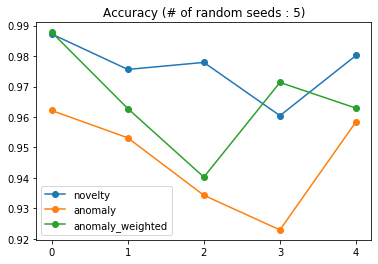

In [69]:
plt.plot(['0', '1', '2', '3', '4'], df_novelty['Accuracy'], label='novelty', marker='o')
plt.plot(['0', '1', '2', '3', '4'], df_anomaly['Accuracy'], label='anomaly', marker='o')
plt.plot(['0', '1', '2', '3', '4'], df_anomaly_weighted['Accuracy'], label='anomaly_weighted', marker='o')
plt.legend()
plt.title('Accuracy (# of random seeds : 5)')
plt.show()

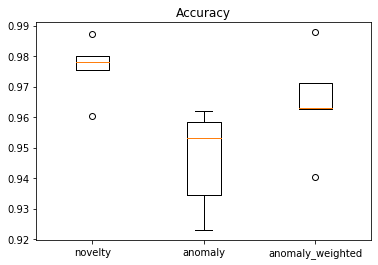

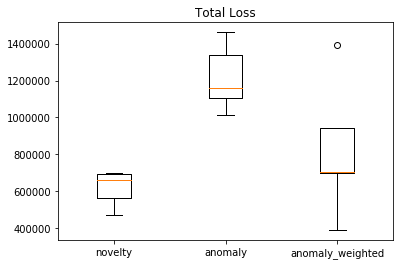

In [12]:
plt.boxplot([df_novelty['Accuracy'],
            df_anomaly['Accuracy'],
            df_anomaly_weighted['Accuracy']])
plt.xticks([1,2,3], ['novelty', 'anomaly', 'anomaly_weighted'])
plt.title('Accuracy')
plt.show()

plt.boxplot([df_novelty['TotalLoss'],
            df_anomaly['TotalLoss'],
            df_anomaly_weighted['TotalLoss']])
plt.xticks([1,2,3], ['novelty', 'anomaly', 'anomaly_weighted'])
plt.title('Total Loss')
plt.show()

# Get Total Loss
- Training하면서 Total Loss를 뽑을때 (prediction이 틀린 샘플 전체 x amount)로 잘못 구함
- (prediction이 틀린 fraud sample x amount)로 다시 계산

In [11]:
from models.vae_novelty import VAE_NOVELTY
from models.vae_anomaly import VAE_ANOMALY
from models.vae_anomaly_amount_weighted import VAE_ANOMALY_WEIGHTED

In [12]:
from sklearn.metrics import roc_curve

def classify(x, cutoff) :
    if x >= cutoff :
        return 1
    else :
        return 0
    
def equal_to_binary(x) :
    if x == True :
        return 0
    elif x == False :
        return 1
    else : 
        return

def get_optimal_cutoff(y, yhat) : 

    fpr, tpr, threshold = roc_curve(y, yhat)
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,threshold))
    
    return j_ordered[-1][1]

In [13]:
total_amount_of_fraud = []
total_loss_novelty = []
total_loss_anomaly = []
total_loss_anomaly_weighted = []

penalty_novelty_uk = []
penalty_novelty_de = []

penalty_anomaly_uk = []
penalty_anomaly_de = []

penalty_anomaly_weighted_uk = []
penalty_anomaly_weighted_de = []

latent_novelty = []
latent_anomaly = []
latent_anomaly_weighted = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
outer = tqdm.tqdm(total=5, desc='Random State', position=0)

for random_state in range(5) : 

    df = pd.read_pickle('data/df_transactions.pkl')
    df = df.drop(['Time'], axis=1)
    normal = df[df['Class']==0]
    novel = df[df['Class']==1]

    novel_train, novel_test = train_test_split(novel, train_size=0.1, random_state = random_state)

    columns = normal.drop(['Class'], axis=1).columns

    # x_train : normal only
    # x_valid : normal only
    # x_test : normal + novelty

    x_train, x_valid = train_test_split(normal, train_size=0.6, random_state=random_state)
    x_valid, x_test = train_test_split(x_valid, train_size=0.5, random_state=random_state)

    #x_train = pd.concat([x_train, novel_train])
    x_test = pd.concat([x_test, novel_test])
    y_test = x_test['Class']
    
    # total amount of fraud in test set, given random seed
    total_amount_of_fraud.append(x_test[x_test['Class']==1]['Amount'].sum())
    
    # scale x_test['Amount']
    standard = StandardScaler()
    standard.fit(x_train['Amount'].values.reshape(-1, 1))
    x_test['Amount'] = standard.transform(x_test['Amount'].values.reshape(-1, 1))
    x_test = x_test.drop(['Class'], axis=1)
    x_test = torch.from_numpy(x_test.values).float()
    x_test = x_test.to(device)

    
    ## 1. novelty
    model_novelty = VAE_NOVELTY().to(device)
    model_novelty.load_state_dict(torch.load('models/best_models/novelty/model_randomstate_%s_epochs_3000.pkl' % random_state))
    x_test_hat_novelty, mu_novelty, logvar_novelty = model_novelty.forward(x_test)
    recon_error_novelty = ((x_test_hat_novelty.cpu().detach().numpy() - x_test.cpu().numpy()) ** 2).mean(axis=1)
    cutoff_novelty = get_optimal_cutoff(y_test.values, recon_error_novelty)
    
    latent_novelty.append([mu_novelty, y_test])
    
    # Check Result
    df_test = pd.DataFrame(x_test.cpu().numpy())
    df_test.columns = columns
    df_test['Amount'] = standard.inverse_transform(df_test['Amount'])
    df_test['ReconError'] = recon_error_novelty
    df_test['Class'] = y_test.values
    df_test['Prediction'] = df_test['ReconError'].apply(lambda x : classify(x, cutoff_novelty))
    df_test['FalseAlram'] = (df_test[df_test['Class']==0]['Class'] == df_test[df_test['Class']==0]['Prediction'])
    df_test['FalseAlram'] = df_test['FalseAlram'].apply(lambda x : equal_to_binary(x))
    df_test['Penalty(UK)'] = penalty_uk * df_test['FalseAlram']
    df_test['Penalty(DE)'] = penalty_de * df_test['FalseAlram']
    penalty_novelty_uk.append(df_test['Penalty(UK)'].sum())
    penalty_novelty_de.append(df_test['Penalty(DE)'].sum())
    df_test['FailedToDetectFraud'] = (df_test[df_test['Class']==1]['Class'] == df_test[df_test['Class']==1]['Prediction'])
    df_test['FailedToDetectFraud'] = df_test['FailedToDetectFraud'].apply(lambda x : equal_to_binary(x))
    df_test['Loss'] = df_test['Amount'] * df_test['FailedToDetectFraud']
    total_loss_novelty.append(df_test['Loss'].sum())
    
    
    ## 2. anomaly
    model_anomaly = VAE_ANOMALY().to(device)
    model_anomaly.load_state_dict(torch.load('models/best_models/anomaly/model_randomstate_%s_epochs_3000.pkl' % random_state))
    x_test_hat_anomaly, mu_anomaly, logvar_anomaly = model_anomaly.forward(x_test)
    recon_error_anomaly = ((x_test_hat_anomaly.cpu().detach().numpy() - x_test.cpu().numpy()) ** 2).mean(axis=1)
    cutoff_anomaly = get_optimal_cutoff(y_test.values, recon_error_anomaly)
    
    latent_anomaly.append([mu_anomaly, y_test])
    
    # Check Result
    df_test = pd.DataFrame(x_test.cpu().numpy())
    df_test.columns = columns
    df_test['Amount'] = standard.inverse_transform(df_test['Amount'])
    df_test['ReconError'] = recon_error_anomaly
    df_test['Class'] = y_test.values
    df_test['Prediction'] = df_test['ReconError'].apply(lambda x : classify(x, cutoff_anomaly))
    df_test['FalseAlram'] = (df_test[df_test['Class']==0]['Class'] == df_test[df_test['Class']==0]['Prediction'])
    df_test['FalseAlram'] = df_test['FalseAlram'].apply(lambda x : equal_to_binary(x))
    df_test['Penalty(UK)'] = penalty_uk * df_test['FalseAlram']
    df_test['Penalty(DE)'] = penalty_de * df_test['FalseAlram']
    penalty_anomaly_uk.append(df_test['Penalty(UK)'].sum())
    penalty_anomaly_de.append(df_test['Penalty(DE)'].sum())
    df_test['FailedToDetectFraud'] = (df_test[df_test['Class']==1]['Class'] == df_test[df_test['Class']==1]['Prediction'])
    df_test['FailedToDetectFraud'] = df_test['FailedToDetectFraud'].apply(lambda x : equal_to_binary(x))
    df_test['Loss'] = df_test['Amount'] * df_test['FailedToDetectFraud']
    total_loss_anomaly.append(df_test['Loss'].sum())
    
    ## 3. anomaly_weighted
    model_anomaly_weighted = VAE_ANOMALY_WEIGHTED().to(device)
    model_anomaly_weighted.load_state_dict(torch.load('models/best_models/anomaly_weighted/model_randomstate_%s_epochs_3000.pkl' % random_state))
    x_test_hat_anomaly_weighted, mu_anomaly_weighted, logvar_anomaly_weighted = model_anomaly.forward(x_test)
    recon_error_anomaly_weighted = ((x_test_hat_anomaly_weighted.cpu().detach().numpy() - x_test.cpu().numpy()) ** 2).mean(axis=1)
    cutoff_anomaly_weighted = get_optimal_cutoff(y_test.values, recon_error_anomaly_weighted)
    
    latent_anomaly_weighted.append([mu_anomaly_weighted, y_test])
    
    # Check Result
    df_test = pd.DataFrame(x_test.cpu().numpy())
    df_test.columns = columns
    df_test['Amount'] = standard.inverse_transform(df_test['Amount'])
    df_test['ReconError'] = recon_error_anomaly_weighted
    df_test['Class'] = y_test.values
    df_test['Prediction'] = df_test['ReconError'].apply(lambda x : classify(x, cutoff_anomaly_weighted))
    df_test['FalseAlram'] = (df_test[df_test['Class']==0]['Class'] == df_test[df_test['Class']==0]['Prediction'])
    df_test['FalseAlram'] = df_test['FalseAlram'].apply(lambda x : equal_to_binary(x))
    df_test['Penalty(UK)'] = penalty_uk * df_test['FalseAlram']
    df_test['Penalty(DE)'] = penalty_de * df_test['FalseAlram']
    penalty_anomaly_weighted_uk.append(df_test['Penalty(UK)'].sum())
    penalty_anomaly_weighted_de.append(df_test['Penalty(DE)'].sum())
    df_test['FailedToDetectFraud'] = (df_test[df_test['Class']==1]['Class'] == df_test[df_test['Class']==1]['Prediction'])
    df_test['FailedToDetectFraud'] = df_test['FailedToDetectFraud'].apply(lambda x : equal_to_binary(x))
    df_test['Loss'] = df_test['Amount'] * df_test['FailedToDetectFraud']
    total_loss_anomaly_weighted.append(df_test['Loss'].sum())
    
    outer.update(1)

Random State:  20%|██        | 1/5 [00:33<02:13, 33.31s/it]

mu_novelty.shape :  torch.Size([57306, 2])


Random State:  40%|████      | 2/5 [00:34<01:11, 23.81s/it]

mu_novelty.shape :  torch.Size([57306, 2])


Random State:  60%|██████    | 3/5 [00:36<00:34, 17.14s/it]

mu_novelty.shape :  torch.Size([57306, 2])


Random State:  80%|████████  | 4/5 [00:38<00:12, 12.49s/it]

mu_novelty.shape :  torch.Size([57306, 2])


Random State: 100%|██████████| 5/5 [00:39<00:00,  9.23s/it]

mu_novelty.shape :  torch.Size([57306, 2])


In [56]:
total_loss_novelty = pd.Series(total_loss_novelty)
total_loss_anomaly = pd.Series(total_loss_anomaly)
total_loss_anomaly_weighted = pd.Series(total_loss_anomaly_weighted)
penalty_novelty_uk = pd.Series(penalty_novelty_uk)
penalty_anomaly_uk = pd.Series(penalty_anomaly_uk)
penalty_anomaly_weighted_uk = pd.Series(penalty_anomaly_weighted_uk)
penalty_novelty_de = pd.Series(penalty_novelty_de)
penalty_anomaly_de = pd.Series(penalty_anomaly_de)
penalty_anomaly_weighted_de = pd.Series(penalty_anomaly_weighted_de)

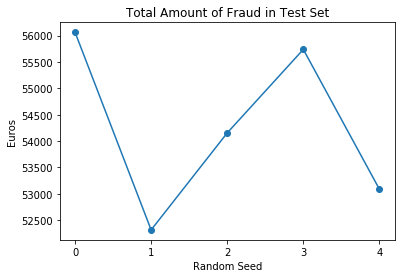

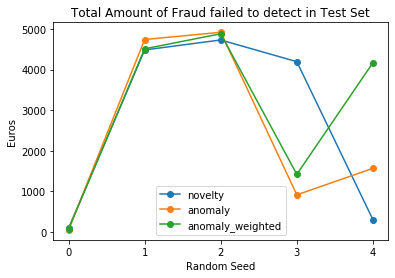

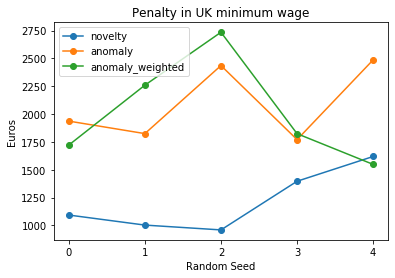

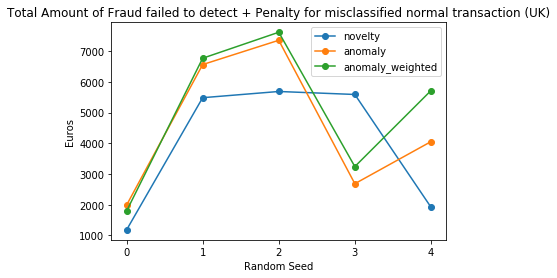

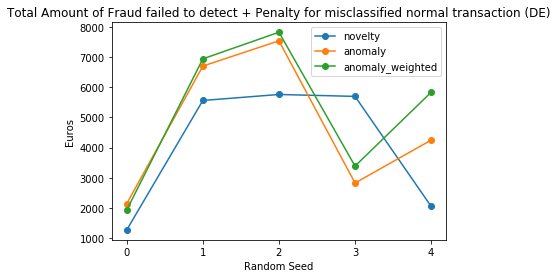

In [66]:
plt.plot(['0', '1', '2', '3', '4'], total_amount_of_fraud, marker='o')
plt.title('Total Amount of Fraud in Test Set')
plt.ylabel('Euros')
plt.xlabel('Random Seed')
plt.show()

plt.plot(['0', '1', '2', '3', '4'], total_loss_novelty, label='novelty', marker='o')
plt.plot(['0', '1', '2', '3', '4'], total_loss_anomaly, label='anomaly', marker='o')
plt.plot(['0', '1', '2', '3', '4'], total_loss_anomaly_weighted, label='anomaly_weighted', marker='o')
plt.title('Total Amount of Fraud failed to detect in Test Set')
plt.ylabel('Euros')
plt.xlabel('Random Seed')
plt.legend()
plt.show()

plt.plot(['0', '1', '2', '3', '4'], penalty_novelty_uk, label='novelty', marker='o')
plt.plot(['0', '1', '2', '3', '4'], penalty_anomaly_uk, label='anomaly', marker='o')
plt.plot(['0', '1', '2', '3', '4'], penalty_anomaly_weighted_uk, label='anomaly_weighted', marker='o')
plt.title('Total Penalty in UK minimum wage')
plt.ylabel('Euros')
plt.xlabel('Random Seed')
plt.legend()
plt.show()

plt.plot(['0', '1', '2', '3', '4'], total_loss_novelty + penalty_novelty_uk, label='novelty', marker='o')
plt.plot(['0', '1', '2', '3', '4'], total_loss_anomaly + penalty_anomaly_uk, label='anomaly', marker='o')
plt.plot(['0', '1', '2', '3', '4'], total_loss_anomaly_weighted + penalty_anomaly_weighted_uk, label='anomaly_weighted', marker='o')
plt.title('Total Amount of Fraud failed to detect + Penalty for misclassified normal transaction (UK)')
plt.ylabel('Euros')
plt.xlabel('Random Seed')
plt.legend()
plt.show()

plt.plot(['0', '1', '2', '3', '4'], total_loss_novelty + penalty_novelty_de, label='novelty', marker='o')
plt.plot(['0', '1', '2', '3', '4'], total_loss_anomaly + penalty_anomaly_de, label='anomaly', marker='o')
plt.plot(['0', '1', '2', '3', '4'], total_loss_anomaly_weighted + penalty_anomaly_weighted_de, label='anomaly_weighted', marker='o')
plt.title('Total Amount of Fraud failed to detect + Penalty for misclassified normal transaction (DE)')
plt.ylabel('Euros')
plt.xlabel('Random Seed')
plt.legend()
plt.show()

In [80]:
def show_latent(latent, given_random_seed) : 
    mu, label = latent[random_seed]
    mu = mu.cpu().detach().numpy()
    mu = mu.reshape(2, -1)
    label = label.reset_index(drop=True)
    normal = label[label==1].index.tolist()
    novelty = label[label==0].index.tolist()
    plt.figure(figsize=(7, 7))
    plt.scatter(mu[0][normal], mu[1][normal], label='normal', alpha=0.3, c='skyblue')
    plt.xlim(min(mu[0][normal].min(), mu[0][novelty].min()), max(mu[0][normal].max(), mu[0][novelty].max()))
    plt.ylim(min(mu[1][normal].min(), mu[1][novelty].min()), max(mu[1][normal].max(), mu[1][novelty].max()))
    plt.title('Normal data on latent space (dim=2)')
    plt.legend()
    plt.show()

    plt.figure(figsize=(7, 7))
    plt.scatter(mu[0][novelty], mu[1][novelty], label='novelty', alpha=0.3, c ='orange')
    plt.xlim(min(mu[0][normal].min(), mu[0][novelty].min()), max(mu[0][normal].max(), mu[0][novelty].max()))
    plt.ylim(min(mu[1][normal].min(), mu[1][novelty].min()), max(mu[1][normal].max(), mu[1][novelty].max()))
    plt.title('Novelty data on latent space (dim=2)')
    plt.legend()
    plt.show()

    plt.figure(figsize=(7, 7))
    plt.scatter(mu[0][normal], mu[1][normal], label='normal', alpha=0.3, c='skyblue')
    plt.scatter(mu[0][novelty], mu[1][novelty], label='novelty', alpha=0.3, c ='orange')
    plt.xlim(min(mu[0][normal].min(), mu[0][novelty].min()), max(mu[0][normal].max(), mu[0][novelty].max()))
    plt.ylim(min(mu[1][normal].min(), mu[1][novelty].min()), max(mu[1][normal].max(), mu[1][novelty].max()))
    plt.title('All data on latent space (dim=2)')
    plt.legend()
    plt.show()

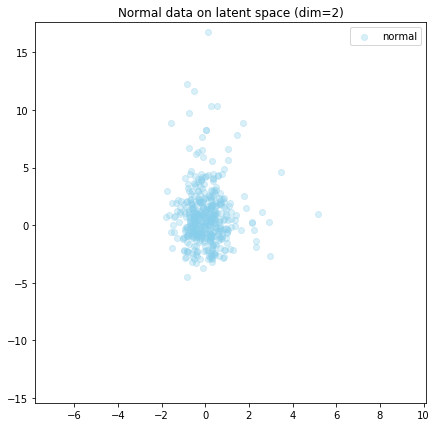

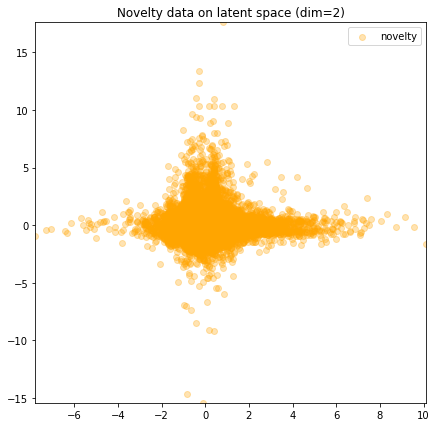

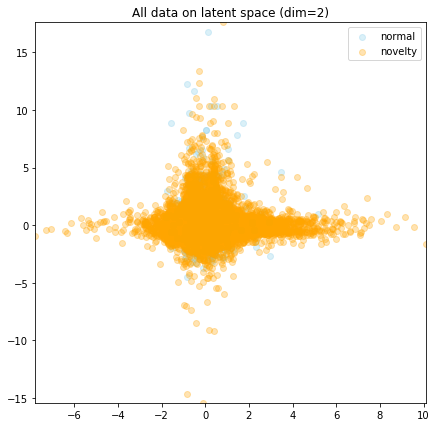

In [81]:
show_latent(latent_novelty, 0)

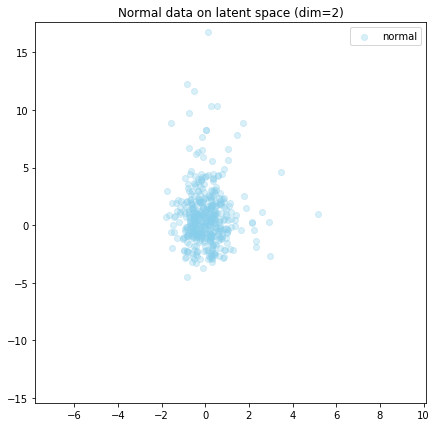

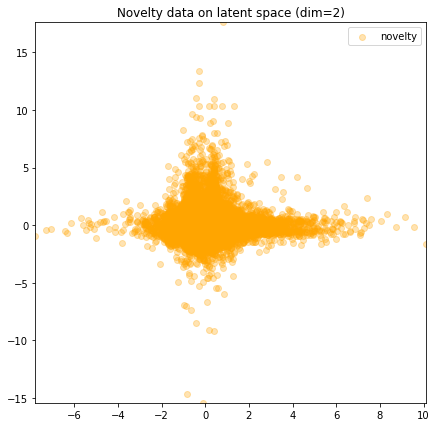

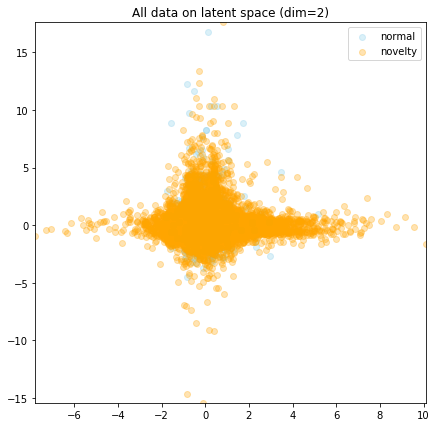

In [82]:
show_latent(latent_novelty, 1)

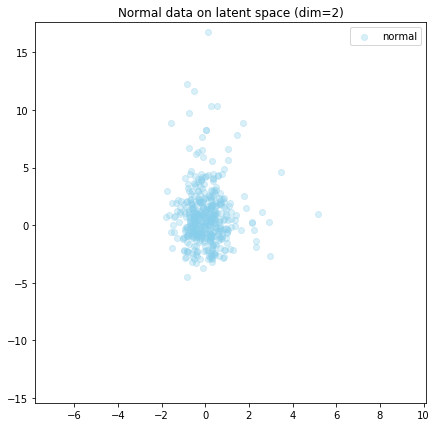

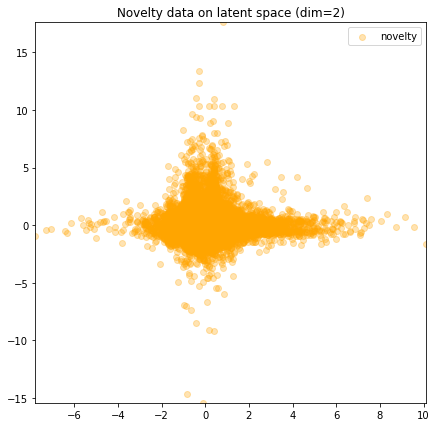

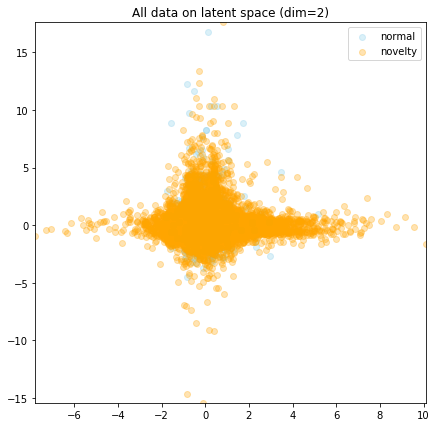

In [83]:
show_latent(latent_novelty, 2)

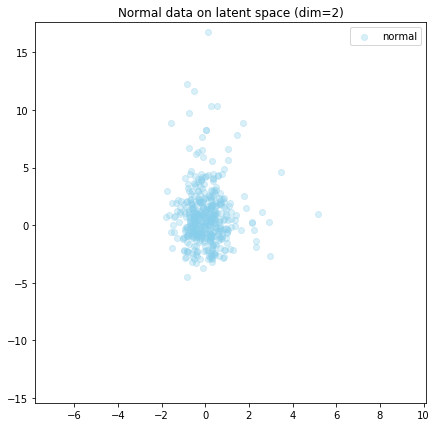

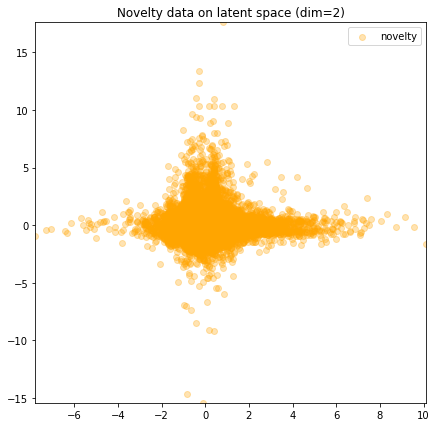

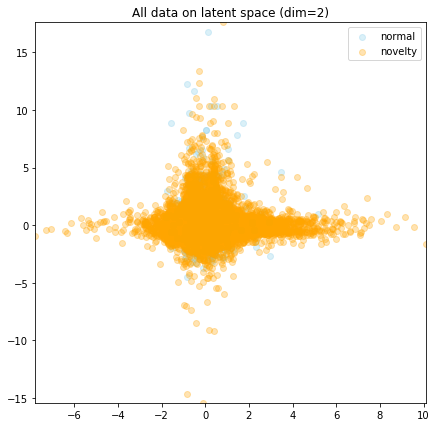

In [84]:
show_latent(latent_novelty, 3)

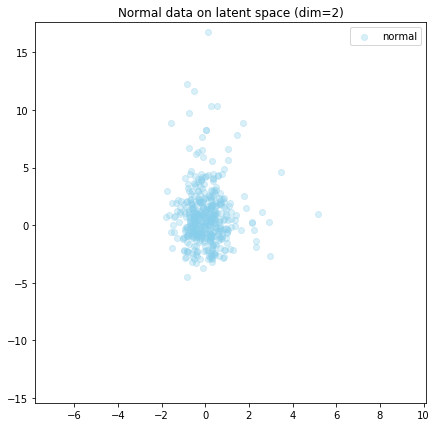

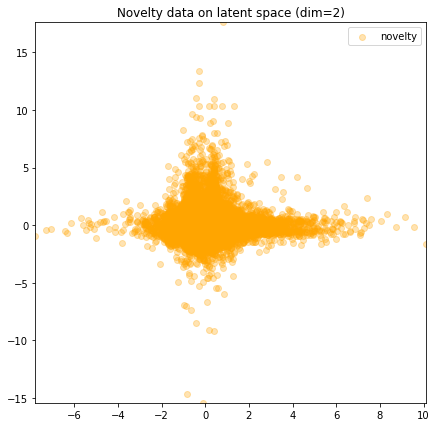

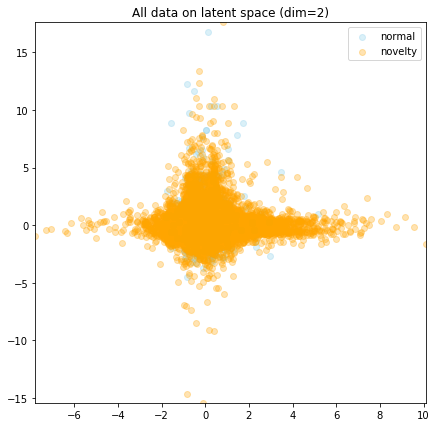

In [85]:
show_latent(latent_novelty, 4)

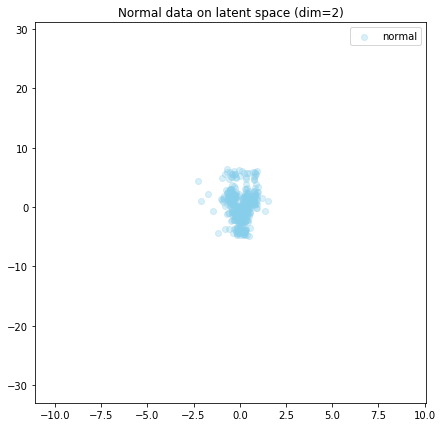

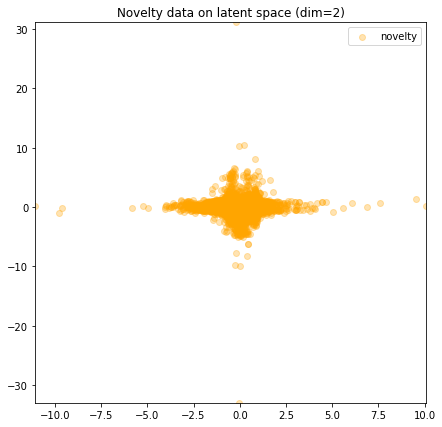

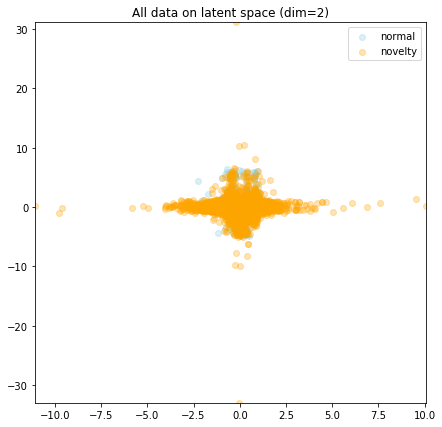

In [86]:
show_latent(latent_anomaly, 0)

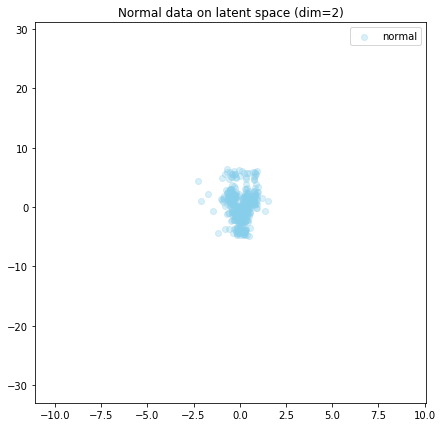

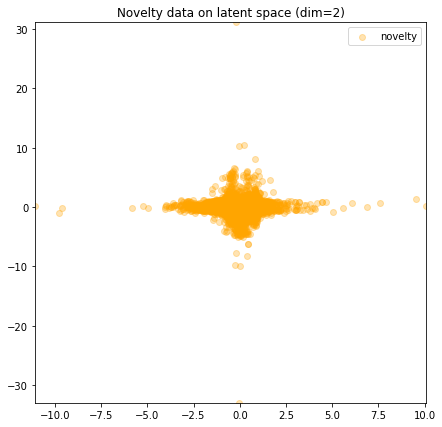

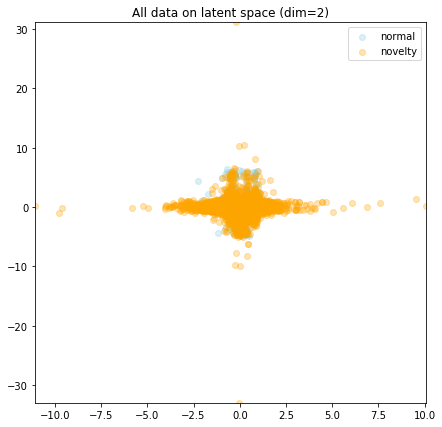

In [87]:
show_latent(latent_anomaly, 1)

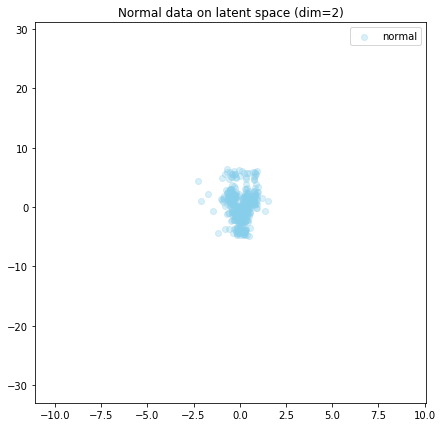

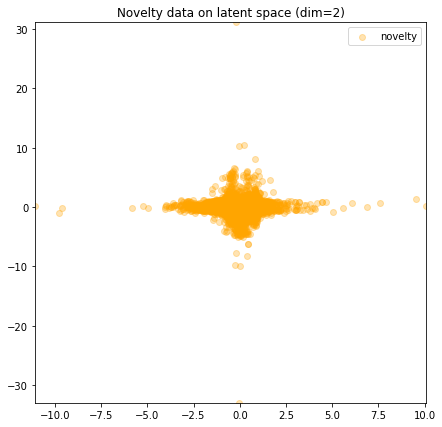

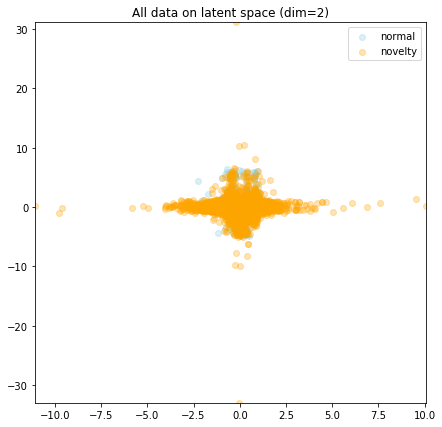

In [88]:
show_latent(latent_anomaly, 2)

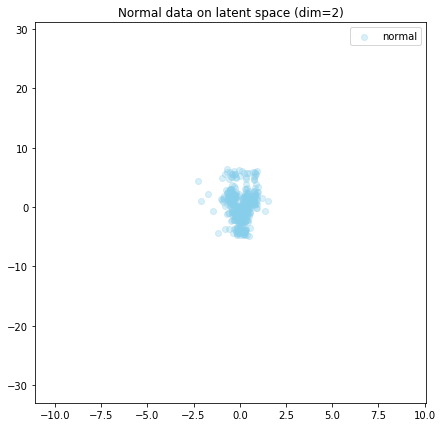

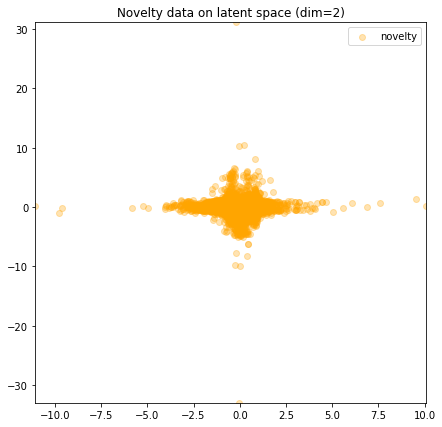

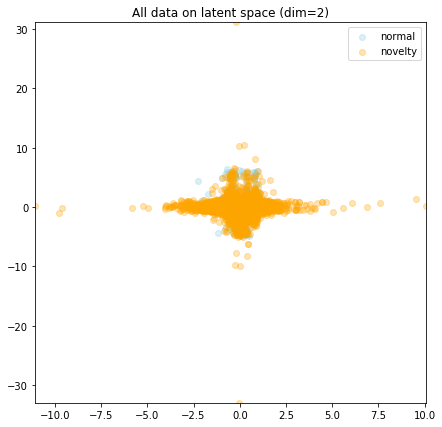

In [89]:
show_latent(latent_anomaly, 3)

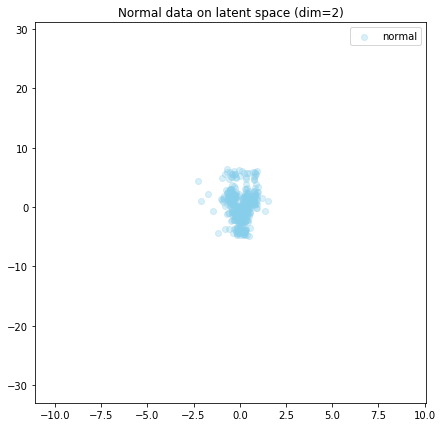

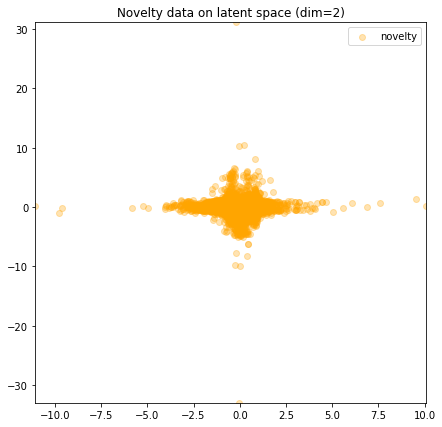

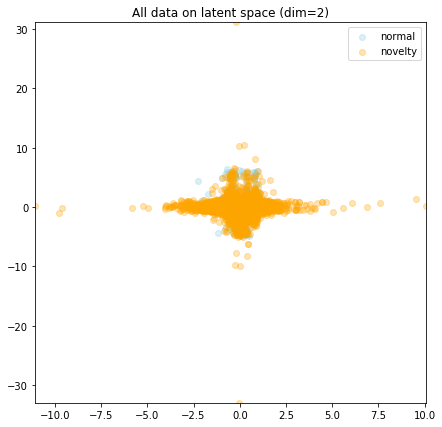

In [90]:
show_latent(latent_anomaly, 4)

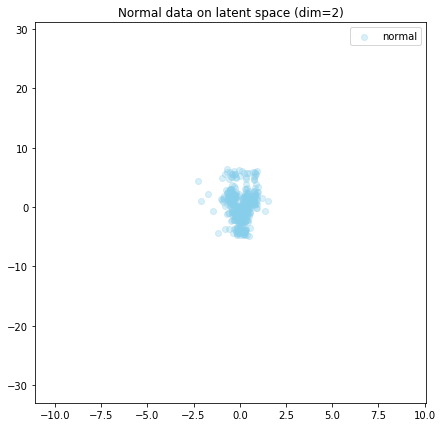

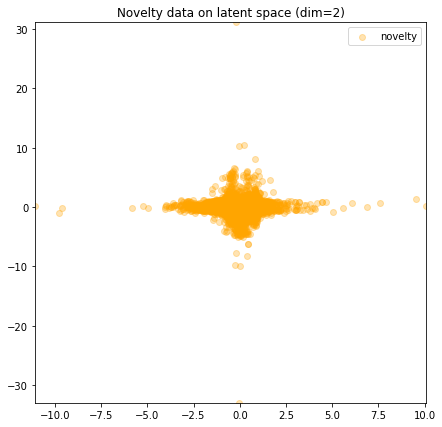

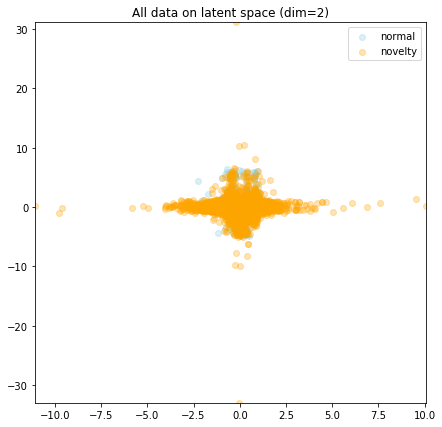

In [91]:
show_latent(latent_anomaly_weighted, 0)

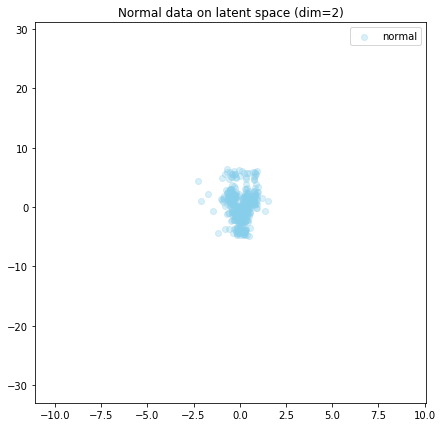

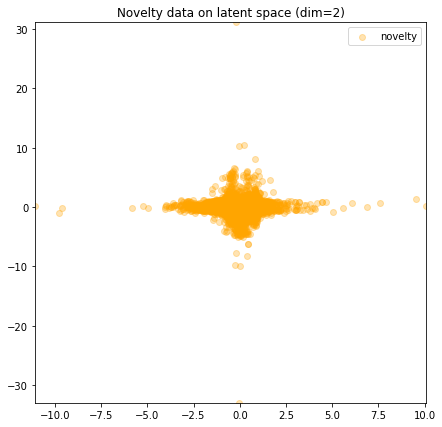

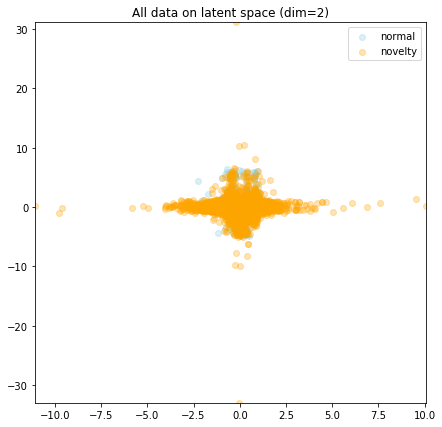

In [92]:
show_latent(latent_anomaly_weighted, 1)

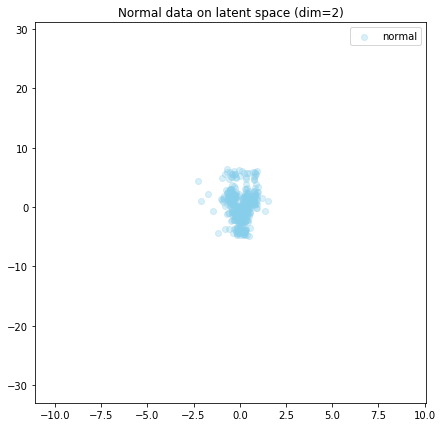

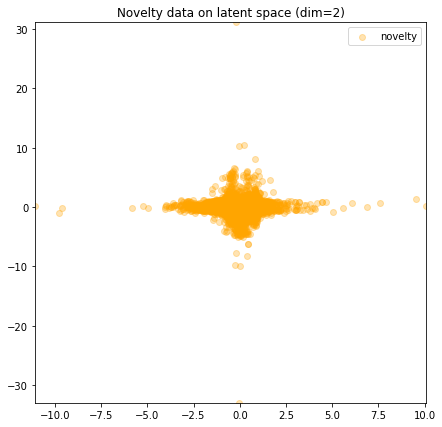

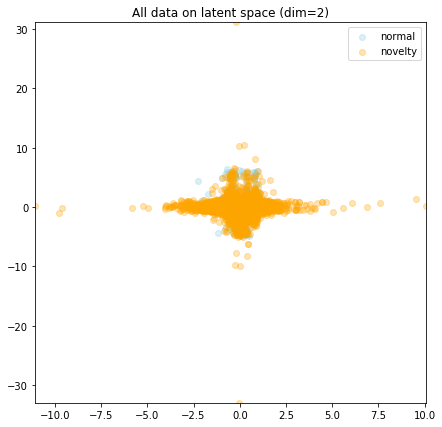

In [93]:
show_latent(latent_anomaly_weighted, 2)

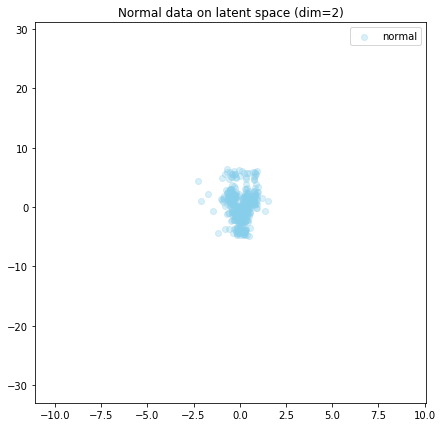

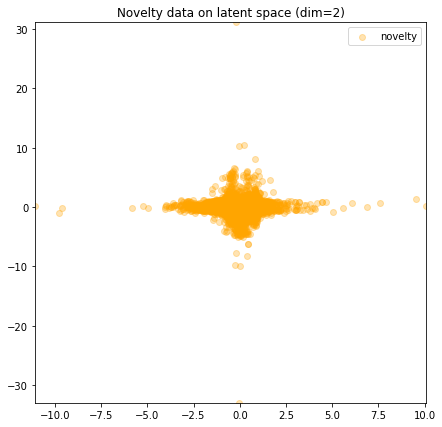

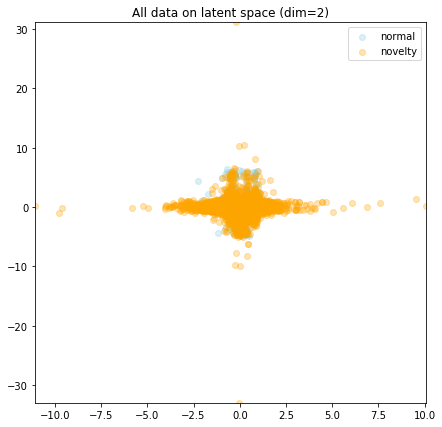

In [94]:
show_latent(latent_anomaly_weighted, 3)

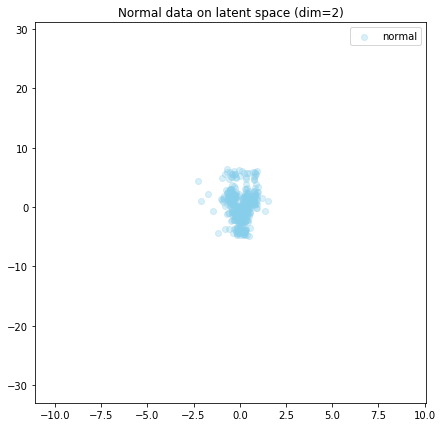

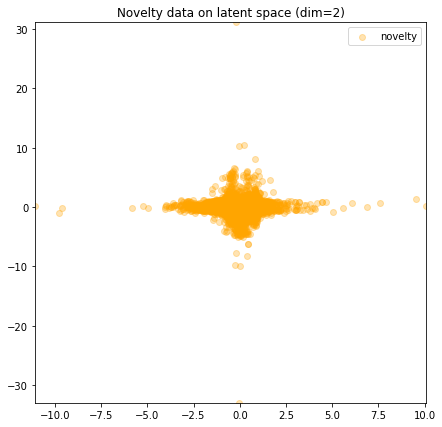

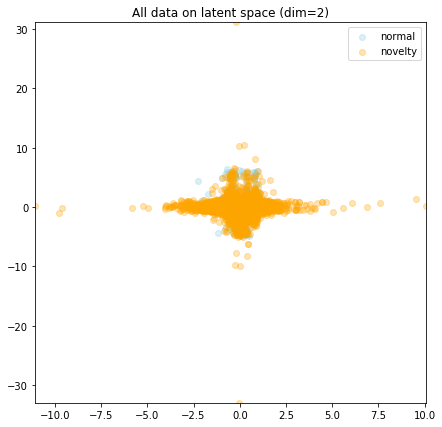

In [95]:
show_latent(latent_anomaly_weighted, 4)